In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
def load_data(train_batch_size, test_batch_size):
    # Fetch training data: total 60000 samples

    trainset = datasets.MNIST('data', train = True, download = True,
                transform = transforms.Compose([
                transforms.ToTensor()
                ]))
    train_loader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size, shuffle=True, num_workers=8)

    testset = datasets.MNIST('data', train = False, download = True,
                transform = transforms.Compose([
                transforms.ToTensor()
                ]))
    test_loader = torch.utils.data.DataLoader(testset ,batch_size = test_batch_size, shuffle=True, num_workers=8)

    return (train_loader, test_loader)

In [5]:
class FlexibleModel(nn.Module):
    def __init__(self, input_size, layer_sizes):
        """
        Initializes a flexible neural network model.

        Parameters:
        - input_size (int): The size of the input layer.
        - layer_sizes (list of int): A list containing the sizes of the hidden and output layers.
        """
        super(FlexibleModel, self).__init__()
        self.layers = nn.ModuleList()
        # Create layers based on the provided sizes
        for i in range(len(layer_sizes)):
            # Input layer to the first hidden layer or connecting between hidden layers
            prev_size = input_size if i == 0 else layer_sizes[i-1]
            self.layers.append(nn.Linear(prev_size, layer_sizes[i]))

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Parameters:
        - x (Tensor): The input tensor.

        Returns:
        - Tensor: The output of the model.
        """
        # Pass input through all layers except the last using ReLU activation
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        # No activation for the last layer
        x = self.layers[-1](x)
        return x


In [6]:
train_batch_size = 50
test_batch_size = 100
train_loader, test_loader = load_data(train_batch_size, test_batch_size)
epochs = 10

100%|██████████| 9912422/9912422 [00:00<00:00, 140499304.68it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 27911450.19it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 151408616.95it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7550744.66it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
def calc_params(model):
    return sum(p.numel() for p in model.parameters())
def define_optimizer(model):
    return optim.Adam(model.parameters(), lr = 0.0001)

In [8]:
def train(model, optimizer, train_loader, loss_fn):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        # Forward propagation
        output = model(data.view(-1, 784))
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

In [9]:
def calculate_loss(model, loader, loss_fn):
    correct = 0
    total = 0
    costTotal = 0
    costCounter = 0
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            output = model(data.view(-1, 784))
            cost = loss_fn(output, target)
            costTotal += cost
            costCounter += 1
            for i, outputTensor in enumerate(output):
                if torch.argmax(outputTensor) == target[i]:
                    correct += 1
                total += 1
    return costTotal / costCounter, round(correct/total, 3)

In [10]:
def compute(model, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs + 1):
        train(model, optimizer, train_loader, loss_fn)
        train_loss, train_acc = calculate_loss(model, train_loader, loss_fn)
        test_loss, test_acc = calculate_loss(model, test_loader, loss_fn)
    loss_train_arr.append(train_loss)
    loss_test_arr.append(test_loss)
    param_arr.append(calc_params(model))
    print("Model Train loss: ", train_loss)
    print("Model Test loss: ", test_loss)
    train_acc_arr.append(train_acc)
    test_acc_arr.append(test_acc)


In [11]:
loss_train_arr = []
loss_test_arr = []
param_arr = []
test_acc_arr = []
train_acc_arr = []

In [12]:
# Configuration for each model could be a tuple/list of layer sizes
model_configurations = [
    [5, 9, 10],
    [25, 50, 10],
    [50, 100, 10],
    [60, 120, 10],
    [100, 200, 10],
    [150, 300, 10],
    [200, 400, 10],
    [250, 500, 10],
    [280, 560, 10],
    [350, 600, 10]
]

# Set the seed once for reproducibility
torch.manual_seed(1)

# Iterate over the model configurations
for i, config in enumerate(model_configurations, 1):
    model = FlexibleModel(784, config)
    print(f"Model {i} parameters: ", calc_params(model))
    optimizer = define_optimizer(model)
    compute(model, optimizer)


Model 1 parameters:  4079
Model Train loss:  tensor(0.5745)
Model Test loss:  tensor(0.5505)
Model 2 parameters:  21435
Model Train loss:  tensor(0.2153)
Model Test loss:  tensor(0.2150)
Model 3 parameters:  45360
Model Train loss:  tensor(0.1684)
Model Test loss:  tensor(0.1770)
Model 4 parameters:  55630
Model Train loss:  tensor(0.1564)
Model Test loss:  tensor(0.1648)
Model 5 parameters:  100710
Model Train loss:  tensor(0.1144)
Model Test loss:  tensor(0.1286)
Model 6 parameters:  166060
Model Train loss:  tensor(0.0829)
Model Test loss:  tensor(0.1050)
Model 7 parameters:  241410
Model Train loss:  tensor(0.0698)
Model Test loss:  tensor(0.0958)
Model 8 parameters:  326760
Model Train loss:  tensor(0.0518)
Model Test loss:  tensor(0.0828)
Model 9 parameters:  382770
Model Train loss:  tensor(0.0430)
Model Test loss:  tensor(0.0723)
Model 10 parameters:  491360
Model Train loss:  tensor(0.0378)
Model Test loss:  tensor(0.0733)


In [19]:
temp_1 = []
for i in loss_train_arr:
    temp_1.append(i.data.numpy().tolist())

temp_2 = []
for i in loss_test_arr:
    temp_2.append(i.data.numpy().tolist())

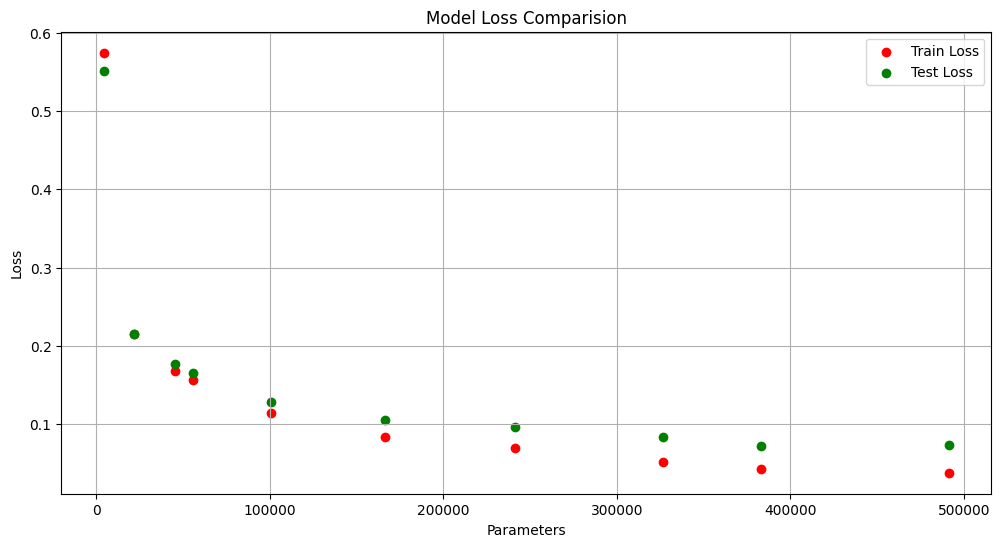

In [23]:
plt.figure(figsize=(12,6))
plt.scatter(param_arr, temp_1, color = "r")
plt.scatter(param_arr, temp_2, color = "g")
plt.title('Model Loss Comparision')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Parameters')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

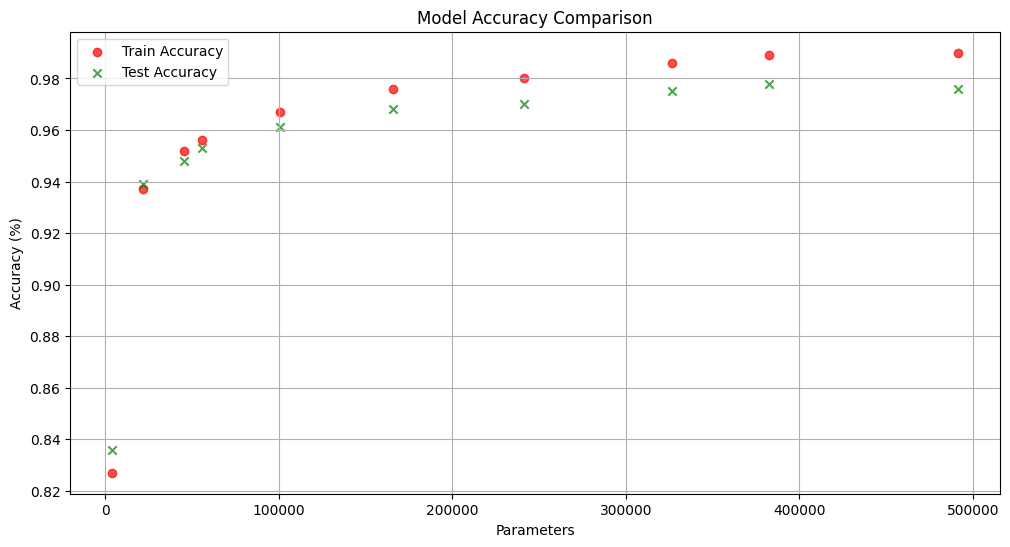

In [16]:
plt.figure(figsize=(12, 6))
plt.scatter(param_arr, train_acc_arr, color="r", marker='o', alpha=0.7, label='Train Accuracy')
plt.scatter(param_arr, test_acc_arr, color="g", marker='x', alpha=0.7, label='Test Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.xlabel('Parameters')
plt.ylabel('Accuracy (%)')
plt.grid(True)  # Adding grid for better readability
plt.show()